# HDAC

Investigate the differences in transcriptome variability between drugs that target the same system

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import scipy.stats as stats

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
import gseapy as gp
from gseapy.plot import gseaplot


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
data_path = '/data_volume/memento/sciplex/'

In [6]:
ct = 'A549'

In [7]:
adata = sc.read(data_path + 'h5ad/{}_HDAC.h5ad'.format(ct))

### Setup memento

In [8]:
adata.obs['q'] = 0.05

In [9]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07)

Version 0.0.6


/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:70: RankWarning: Polyfit may be poorly conditioned


### One sample test

In [9]:
subset = adata[(adata.obs.target == 'HDAC') & (adata.obs.dose == 10000)].copy().copy()

memento.create_groups(subset, label_columns=['product_name'])
memento.compute_1d_moments(subset, min_perc_group=.9)
memento.ht_1d_moments(
    subset, 
    formula_like='1',
    cov_column='Inter', 
    num_boot=10000, 
    verbose=1,
    num_cpus=90)

# subset.write(data_path + 'hdac/{}_vs_vehicle.h5ad'.format(drug))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
[Parallel(n_jobs=90)]: Using backend LokyBackend with 90 concurrent workers.
[Parallel(n_jobs=90)]: Done  20 tasks      | elapsed:    4.6s
[Parallel(n_jobs=90)]: Done 270 tasks      | elapsed:    7.9s
[Parallel(n_jobs=90)]: Done 620 tasks      | elapsed:   12.6s
[Parallel(n_jobs=90)]: Done 1070 tasks      | elapsed:   18.6s
[Parallel(n_jobs=90)]: Done 1620 tasks      | elapsed:   26.1s
[Parallel(n_jobs=90)]: Done 2326 out of 2326 | elapsed:   38.2s finished


In [10]:
df = memento.get_1d_ht_result(subset)
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])

### GSEA

In [25]:
import gseapy as gp
from gseapy.plot import gseaplot


In [26]:
pre_res = gp.prerank(
    rnk=df[['gene','dv_coef']].sort_values('dv_coef'), 
    gene_sets='GO_Biological_Process_2018',
    processes=14,
    permutation_num=100, # reduce number to speed up testing
    outdir=None, seed=6)

### Comparison to control, using dosage as treatment

Use different drugs as strata

In [10]:
drug_counts = adata.obs.query('~vehicle').product_name.value_counts()
drug_list = drug_counts[drug_counts > 0].index.tolist()

In [11]:
drug_list = [
    'Pracinostat (SB939)',
    'Quisinostat (JNJ-26481585) 2HCl',
    'Abexinostat (PCI-24781)',
    'Mocetinostat (MGCD0103)',
    'Divalproex Sodium',
    'M344',
    'Resminostat',
    'Panobinostat (LBH589)'
]

In [84]:
drug = drug_list[0]
# subset = adata[((adata.obs.target == target))].copy().copy()
subset = adata.copy().copy()
# subset.obs['dose_indicator'] = (subset.obs.product_name == drug).astype(int)
subset.obs['dose_indicator'] = subset.obs.dose.apply(lambda x: {0:0.0 ,10:1.0, 100:2.0, 1000:3.0, 10000:4.0}[x])
subset.obs['dose_level'] = 'dose_' + subset.obs['dose'].astype(str)

memento.create_groups(subset, label_columns=['dose_indicator', 'product_name'])
memento.compute_1d_moments(subset, min_perc_group=.9)
memento.ht_1d_moments(
    subset, 
    formula_like='1 + dose_indicator + product_name',
    treatment_col='dose_indicator', 
    num_boot=20000, 
    verbose=1,
    num_cpus=92,
    resampling='permutation',
    approx=False)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:   13.2s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:   34.1s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:  1.1min
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:  1.7min
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:  2.5min
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:  3.5min
[Parallel(n_jobs=92)]: Done 2636 out of 2636 | elapsed:  5.0min finished


In [85]:
df = memento.get_1d_ht_result(subset)
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])

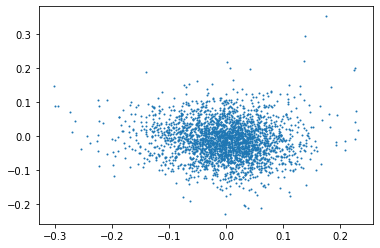

In [86]:
plt.scatter(df['de_coef'], df['dv_coef'], s=1)

In [91]:
df.query('gene == "STAT3"')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr,de_fdr
1995,STAT3,0.167016,0.00595,2.113064e-09,-0.082061,0.017384,0.000059,0.010424,0.000006


In [121]:
pre_res = gp.prerank(rnk=df.sort_values('de_coef', ascending=False)[['gene', 'de_coef']], 
                     gene_sets='WikiPathways_2019_Human',
                     processes=4,
                     permutation_num=100, # reduce number to speed up testing
                     outdir=None, seed=6)
pre_res.res2d.sort_index().query('fdr < 0.1')


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Cytoplasmic Ribosomal Proteins WP477,0.539018,2.047713,0.0,0.006825,89,60,RPS5;RPL28;RPS2;RPL7A;RPL26;RPL8;RPL11;RPL18;R...,RPS5;RPL28;RPS2;RPL7A;RPL26;RPL8;RPL11;RPL18;R...
Sterol Regulatory Element-Binding Proteins (SREBP) signalling WP1982,0.741998,2.238535,0.0,0.013650,69,23,FDFT1;FASN;LPIN1;SREBF1;HMGCS1;SQLE;ACLY;SCD;L...,FDFT1;FASN;LPIN1;SREBF1;HMGCS1;SQLE;ACLY;SCD;L...


In [ ]:
enr = gp.enrichr(gene_list=df.query('de_fdr < 0.01 & de_coef > 0').sort_values('dv_coef', ascending=False).gene,
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [100]:
df.query('de_fdr < 0.01 & de_coef > 0 & dv_fdr < 0.1 & dv_coef < 0').sort_values('dv_coef', ascending=False).gene.shape

(58,)

In [123]:
enr = gp.enrichr(gene_list=df.query('de_fdr < 0.1 & de_coef > 0').sort_values('dv_coef', ascending=False).gene,
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
enr.results.sort_values('Adjusted P-value').head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Human,Cytoplasmic Ribosomal Proteins WP477,41/89,4.314994e-30,1.613808e-27,0,0,17.181159,1161.711945,RPL4;RPL5;RPL3;RPL32;RPLP1;RPLP0;RPL11;RPL10A;...
1,WikiPathways_2019_Human,VEGFA-VEGFR2 Signaling Pathway WP3888,41/236,1.503542e-12,2.811623e-10,0,0,4.196433,114.240313,GSK3B;ROCK2;CLTC;PXN;IQGAP1;FOXO3;ACACA;FOXO1;...
2,WikiPathways_2019_Human,Leptin signaling pathway WP2034,19/76,3.145788e-09,3.921749e-07,0,0,6.548877,128.208691,GSK3B;KHDRBS1;MAP2K1;ROCK2;STAT1;RPS6;STAT3;PT...
3,WikiPathways_2019_Human,Physiological and Pathological Hypertrophy of...,10/25,1.320185e-07,1.234373e-05,0,0,13.005476,206.010946,PPP3CA;PPP3CB;MAPK8;STAT3;MAPK1;RAC1;IL6ST;CAL...
4,WikiPathways_2019_Human,IL-5 Signaling Pathway WP127,12/40,2.926317e-07,1.968421e-05,0,0,8.372134,125.953322,GSK3B;MAP2K1;RPS6KB1;STAT1;STAT3;RPS6;MAPK1;PT...
5,WikiPathways_2019_Human,Regulation of Actin Cytoskeleton WP51,24/150,3.175682e-07,1.968421e-05,0,0,3.748016,56.079963,MAP2K1;PPP1R12A;ROCK2;PXN;RDX;RRAS2;IQGAP1;PIK...
6,WikiPathways_2019_Human,EGF/EGFR Signaling Pathway WP437,25/162,3.684210e-07,1.968421e-05,0,0,3.592360,53.217359,RALA;STXBP1;PTEN;CBLB;AP2A1;IQGAP1;FOXO1;MAPK8...
7,WikiPathways_2019_Human,Oncostatin M Signaling Pathway WP2374,15/65,4.422392e-07,2.067468e-05,0,0,5.871827,85.913132,MAP2K1;STAT1;SERPINE1;RPS6;PXN;STAT3;PTPN11;HI...
9,WikiPathways_2019_Human,Prolactin Signaling Pathway WP2037,16/76,6.990445e-07,2.382580e-05,0,0,5.222039,74.014832,GSK3B;MAP2K1;STAT1;RPS6;PXN;STAT3;PTPN11;MAPK8...
10,WikiPathways_2019_Human,IL-6 signaling pathway WP364,12/43,7.007588e-07,2.382580e-05,0,0,7.560733,107.143916,GSK3B;MAP2K1;RPS6KB1;STAT1;STAT3;MAPK1;PTPN11;...


In [125]:
enr = gp.enrichr(gene_list=df.query('dv_fdr < 0.1').sort_values('dv_coef', ascending=False).gene,
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
enr.results.sort_values('Adjusted P-value').head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Human,Pathways in clear cell renal cell carcinoma WP...,9/85,9.174578e-08,0.000026,0,0,13.281325,215.213832,ACLY;PKM;STAT3;PTEN;PLOD2;ENO1;SQSTM1;GAPDH;ACACA
1,WikiPathways_2019_Human,Nuclear Receptors Meta-Pathway WP2882,15/319,3.001337e-07,0.000043,0,0,5.663022,85.053149,ABCC3;NQO1;ABCC2;NCOA3;TXNRD1;STAT3;SLC7A11;PT...
2,WikiPathways_2019_Human,NRF2 pathway WP2884,9/146,8.879122e-06,0.000844,0,0,7.344973,85.435320,ABCC3;NQO1;ABCC2;TXNRD1;BLVRB;SLC7A11;PTGR1;SQ...
3,WikiPathways_2019_Human,Pathways Affected in Adenoid Cystic Carcinoma ...,6/65,3.033040e-05,0.002028,0,0,11.223937,116.766659,MORF4L1;FBXW7;PRKDC;KMT2C;PTEN;JMJD1C
4,WikiPathways_2019_Human,Metabolic reprogramming in colon cancer WP4290,5/42,4.134115e-05,0.002028,0,0,14.848348,149.874063,ACLY;PKM;ENO1;GAPDH;GLS
5,WikiPathways_2019_Human,Sterol Regulatory Element-Binding Proteins (SR...,6/69,4.269362e-05,0.002028,0,0,10.509178,105.737686,ACLY;HMGCS1;PPARG;LPIN1;LDLR;ACACA
6,WikiPathways_2019_Human,Nuclear Receptors in Lipid Metabolism and Toxi...,4/33,2.350995e-04,0.009572,0,0,15.077920,125.983582,ABCC3;ABCC2;CYP24A1;PPARG
7,WikiPathways_2019_Human,Oncostatin M Signaling Pathway WP2374,5/65,3.381020e-04,0.012045,0,0,9.145833,73.094990,SERPINE1;STAT3;MAPK1;IL6ST;LDLR
8,WikiPathways_2019_Human,Leptin signaling pathway WP2034,5/76,6.968164e-04,0.022066,0,0,7.724570,56.149809,CCND1;STAT3;PTEN;MAPK1;ACACA
9,WikiPathways_2019_Human,TCA Cycle Nutrient Utilization and Invasivenes...,2/5,8.355526e-04,0.023813,0,0,72.174863,511.533373,STAT3;MAPK1


In [120]:
enr = gp.enrichr(gene_list=df.query('dv_fdr < 0.1 & dv_coef > 0').sort_values('dv_coef', ascending=False).gene,
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
enr.results.sort_values('Adjusted P-value').head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Human,NRF2 pathway WP2884,7/146,0.000002,0.000245,0,0,14.233094,190.862999,ABCC3;NQO1;ABCC2;SLC7A11;PTGR1;SQSTM1;FTL
1,WikiPathways_2019_Human,Sterol Regulatory Element-Binding Proteins (SR...,5/69,0.000007,0.000415,0,0,21.548394,256.160093,ACLY;HMGCS1;PPARG;LPIN1;ACACA
2,WikiPathways_2019_Human,Nuclear Receptors in Lipid Metabolism and Toxi...,4/33,0.000008,0.000415,0,0,37.589041,442.910759,ABCC3;ABCC2;CYP24A1;PPARG
3,WikiPathways_2019_Human,Pathways in clear cell renal cell carcinoma WP...,5/85,0.000019,0.000779,0,0,17.224826,187.138321,ACLY;PTEN;PLOD2;SQSTM1;ACACA
4,WikiPathways_2019_Human,Nuclear Receptors Meta-Pathway WP2882,8/319,0.000031,0.001012,0,0,7.311431,75.891661,ABCC3;NQO1;ABCC2;CCND1;SLC7A11;PTGR1;SQSTM1;FTL
5,WikiPathways_2019_Human,Photodynamic therapy-induced NFE2L2 (NRF2) sur...,3/24,0.000105,0.002846,0,0,38.420849,352.080017,ABCC3;NQO1;ABCC2
6,WikiPathways_2019_Human,Codeine and Morphine Metabolism WP1604,2/15,0.001487,0.030299,0,0,40.841026,265.913334,ABCC3;ABCC2
7,WikiPathways_2019_Human,Phytochemical activity on NRF2 transcriptional...,2/15,0.001487,0.030299,0,0,40.841026,265.913334,NQO1;SLC7A11
8,WikiPathways_2019_Human,Drug Induction of Bile Acid Pathway WP2289,2/17,0.001917,0.032908,0,0,35.392000,221.455839,ABCC3;ABCC2
9,WikiPathways_2019_Human,Pathways Affected in Adenoid Cystic Carcinoma ...,3/65,0.002019,0.032908,0,0,12.986704,80.585012,MORF4L1;PTEN;JMJD1C


In [116]:
enr = gp.enrichr(gene_list=df.query('dv_fdr < 0.1 & dv_coef < 0').sort_values('dv_coef', ascending=False).gene,
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
enr.results.sort_values('Adjusted P-value').head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Human,Oncostatin M Signaling Pathway WP2374,5/65,0.000027,0.005581,0,0,16.045307,168.970040,SERPINE1;STAT3;MAPK1;IL6ST;LDLR
1,WikiPathways_2019_Human,Metabolic reprogramming in colon cancer WP4290,4/42,0.000077,0.008030,0,0,20.095142,190.376389,PKM;ENO1;GAPDH;GLS
2,WikiPathways_2019_Human,TCA Cycle Nutrient Utilization and Invasivenes...,2/5,0.000286,0.013501,0,0,125.088050,1020.721936,STAT3;MAPK1
3,WikiPathways_2019_Human,Hypothesized Pathways in Pathogenesis of Cardi...,3/25,0.000323,0.013501,0,0,25.805195,207.419168,SERPINE1;FLNA;MAPK1
4,WikiPathways_2019_Human,Physiological and Pathological Hypertrophy of...,3/25,0.000323,0.013501,0,0,25.805195,207.419168,STAT3;MAPK1;IL6ST
5,WikiPathways_2019_Human,IL17 signaling pathway WP2112,3/31,0.000617,0.021477,0,0,20.269388,149.818471,STAT3;MAPK1;MAP3K14
15,WikiPathways_2019_Human,Glycolysis and Gluconeogenesis WP534,3/45,0.001843,0.024069,0,0,13.503401,85.025430,PKM;ENO1;GAPDH
14,WikiPathways_2019_Human,MAPK and NFkB Signalling Pathways Inhibited b...,2/12,0.001841,0.024069,0,0,37.513208,236.245592,MAPK1;MAP3K14
13,WikiPathways_2019_Human,IL-10 Anti-inflammatory Signaling Pathway WP4495,2/12,0.001841,0.024069,0,0,37.513208,236.245592,STAT3;BLVRB
12,WikiPathways_2019_Human,Bile Acids synthesis and enterohepatic circula...,2/12,0.001841,0.024069,0,0,37.513208,236.245592,MAPK1;LDLR


### Multiclass comparison

In [ ]:
subset = adata[~adata.obs.vehicle].copy().copy()
subset.obs['dose_level'] = 'dose_' + subset.obs['dose'].astype(str)

memento.create_groups(subset, label_columns=['product_name', 'dose_level'])
memento.compute_1d_moments(subset, min_perc_group=.9)
memento.ht_1d_moments(
    subset, 
    formula_like='1 + product_name + dose_level',
    treatment_col='product_name', 
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='permutation',
    approx=False)

### Drug-drug comparisons

Investigate if including the dosage changes anything

In [126]:
drug_counts = adata.obs.query('~vehicle').product_name.value_counts()
drug_list = drug_counts[drug_counts > 0].index.tolist()

In [127]:
drug_list = drug_counts[drug_counts > 0].index.tolist()
drug_list = [
    'Pracinostat (SB939)',
    'Quisinostat (JNJ-26481585) 2HCl',
    'Abexinostat (PCI-24781)',
    'Mocetinostat (MGCD0103)',
    'Divalproex Sodium',
    'M344',
    'Resminostat',
    'Panobinostat (LBH589)'
]

In [128]:
len(list(itertools.combinations(drug_list,2)))

28

In [52]:
# for drug1, drug2 in itertools.combinations(drug_list,2):
    
#     print(drug1, drug2)

#     subset = adata[adata.obs.product_name.isin([drug1, drug2]) & (adata.obs.dose == 10000)].copy().copy()
#     subset.obs['is_drug1'] = (subset.obs.product_name==drug1).astype(int)
    
#     memento.create_groups(subset, label_columns=['is_drug1'])
#     memento.compute_1d_moments(subset, min_perc_group=.9)
#     memento.ht_1d_moments(
#         subset, 
#         formula_like='1 + is_drug1',
#         cov_column='is_drug1', 
#         num_boot=10000, 
#         verbose=0,
#         num_cpus=94)
    
#     subset.write(data_path + 'hdac/{}_vs_{}_10000.h5ad'.format(drug1, drug2))

In [53]:
for drug1, drug2 in itertools.combinations(drug_list,2):
    
    print(drug1, drug2)

    subset = adata[adata.obs.product_name.isin([drug1, drug2])].copy().copy()
    subset.obs['is_drug1'] = (subset.obs.product_name==drug1).astype(int)
    subset.obs['dose_level'] = 'dose_' + subset.obs['dose'].astype(str)
    
    memento.create_groups(subset, label_columns=['is_drug1', 'dose_level'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + is_drug1 + dose_level',
        treatment_col='is_drug1', 
        num_boot=10000, 
        verbose=0,
        num_cpus=94,
        resampling='permutation',
        approx=False)
    
    break
    
#     subset.write(data_path + 'hdac/{}_vs_{}_stratified.h5ad'.format(drug1, drug2))

Pracinostat (SB939) Quisinostat (JNJ-26481585) 2HCl


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [54]:
df = memento.get_1d_ht_result(subset)

In [55]:
df.head(5)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,DPM1,-0.851508,0.160348,0.000156,0.012935,0.464351,0.973503
1,GCLC,-0.538679,0.074793,0.000026,0.030494,0.269604,0.907809
2,NIPAL3,-0.504813,0.140485,0.001047,-0.448085,0.721960,0.497650
3,ANKIB1,-0.168532,0.068478,0.015398,0.244711,0.404220,0.510749
4,KRIT1,-0.045940,0.106558,0.663034,-0.102626,0.540612,0.840916


In [56]:
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])


(array([370., 247., 216., 205., 223., 190., 195., 242., 191., 217.]),
 array([5.29171537e-06, 9.99547675e-02, 1.99904243e-01, 2.99853719e-01,
        3.99803195e-01, 4.99752671e-01, 5.99702147e-01, 6.99651623e-01,
        7.99601098e-01, 8.99550574e-01, 9.99500050e-01]),
 <BarContainer object of 10 artists>)

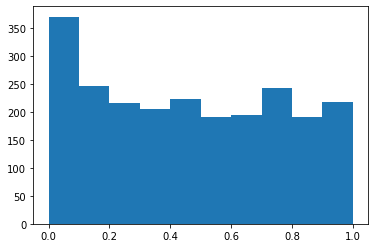

In [57]:
plt.hist(df.dv_pval)

In [25]:
df.shape

(2296, 9)

In [35]:
np.log(5)

1.6094379124341003

In [62]:
df.query('de_fdr < 0.01 & dv_fdr < 0.1')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr,de_fdr
69,CYP24A1,1.150603,0.044865,4.643838e-05,-1.028279,0.106781,0.000024,0.018152,0.000454
80,ABCC2,1.709010,0.061607,6.133109e-08,-1.038730,0.229475,0.000526,0.092416,0.000060
156,SLC2A3,-0.437062,0.103900,4.403312e-04,1.101184,0.223922,0.000629,0.092416,0.001679
172,SLC12A2,0.779810,0.045925,4.936197e-06,1.023300,0.146709,0.000219,0.073210,0.000214
640,ABCC3,1.882920,0.046963,9.368183e-07,-0.999254,0.091413,0.000005,0.012150,0.000143
733,PDE4D,0.932329,0.029513,1.655617e-07,-0.809061,0.087720,0.000013,0.014758,0.000076
989,MTUS1,1.254447,0.043332,4.889577e-05,-0.505098,0.128685,0.000598,0.092416,0.000468
1349,MARCH6,-1.257451,0.106161,6.432183e-06,-2.534201,0.496368,0.000676,0.092416,0.000240
1389,DOCK5,0.883395,0.052375,1.921278e-06,-0.812667,0.180799,0.000365,0.080419,0.000178
1473,CAST,0.556643,0.044350,1.805176e-04,0.714769,0.150872,0.000385,0.080419,0.000978


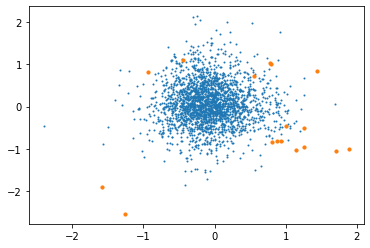

In [61]:
plt.scatter(df['de_coef'], df['dv_coef'], s=1)
plt.scatter(df.query('dv_fdr < 0.1')['de_coef'], df.query('dv_fdr < 0.1')['dv_coef'], s=10)

### Combine P-values

In [13]:
dv_pvals = pd.DataFrame()
start = True
for drug1, drug2 in itertools.combinations(drug_list,2):
    
    subset = sc.read(data_path + 'hdac/{}_vs_{}_stratified.h5ad'.format(drug1, drug2))
    df = memento.get_1d_ht_result(subset)
    if start:
        
        dv_pvals['gene'] = df['gene']
        dv_pvals['{}_{}'.format(drug1, drug2)] = df['dv_pval']
        start = False
    else:
        dv_pvals = dv_pvals.merge(df[['gene', 'dv_pval']].rename(columns={'dv_pval':'{}_{}'.format(drug1, drug2)}), how='outer')
        
# dv_pvals = pd.DataFrame()
# start = True
# for drug1, drug2 in itertools.combinations(drug_list,2):
    
#     subset = sc.read(data_path + 'hdac/{}_vs_{}_10000.h5ad'.format(drug1, drug2))
#     df = memento.get_1d_ht_result(subset)
#     if start:
        
#         dv_pvals['gene'] = df['gene']
#         dv_pvals['{}_{}'.format(drug1, drug2)] = df['de_pval']
#         start = False
#     else:
#         dv_pvals = dv_pvals.merge(df[['gene', 'de_pval']].rename(columns={'de_pval':'{}_{}'.format(drug1, drug2)}), how='outer')

In [14]:
combined_pvals = []
for g in dv_pvals.gene:
    pvalues = dv_pvals.query('gene == "{}"'.format(g)).iloc[0, 1:].values.astype(float)
    chisq, pv = stats.combine_pvalues(pvalues[np.isfinite(pvalues)])
    combined_pvals.append((g, chisq, pv))

In [15]:
combined_pvals = pd.DataFrame(combined_pvals, columns=['gene', 'chisq', 'pv'])
combined_pvals['fdr'] = memento.util._fdrcorrect(combined_pvals['pv'])

In [16]:
g = 'IDI1;ACLY;INSIG1;DHCR24;FDFT1'.split(';')

### GSEA + Enrichr

IDI1;ACLY;INSIG1;DHCR24;FDFT1

In [17]:
# for gene in combined_pvals.query('fdr < 0.01').sort_values('fdr').gene:
#     print(gene)

In [18]:
import gseapy as gp
from gseapy.plot import gseaplot


In [19]:
# pre_res = gp.prerank(rnk=combined_pvals.sort_values('chisq', ascending=False)[['gene', 'chisq']], gene_sets='GO_Biological_Process_2021',
#                      processes=90,
#                      permutation_num=100, # reduce number to speed up testing
#                      outdir=None,seed=6)

In [20]:
# pre_res.res2d.sort_index().head(30)


In [31]:
import gseapy as gp
from gseapy.plot import gseaplot

enr = gp.enrichr(gene_list=combined_pvals.query('fdr < 0.01').sort_values('fdr').gene,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
enr.results.sort_values('Adjusted P-value').head(30)

In [32]:
enr.results.sort_values('Adjusted P-value').head(30)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,morphogenesis of a polarized epithelium (GO:00...,4/12,6.280790e-07,0.000629,0,0,84.194915,1202.353897,RAB10;AHI1;LAMA5;ACTB
1,GO_Biological_Process_2021,pyruvate metabolic process (GO:0006090),6/55,1.033615e-06,0.000629,0,0,20.931386,288.485741,LDHB;PKM;BSG;ME1;ENO1;GAPDH
2,GO_Biological_Process_2021,axonogenesis (GO:0007409),8/240,1.137169e-04,0.036332,0,0,5.942529,53.968846,RAB10;AFG3L2;LAMA5;SEMA3C;PARD3;BSG;ACTB;ROBO1
3,GO_Biological_Process_2021,regulated exocytosis (GO:0045055),7/180,1.194135e-04,0.036332,0,0,6.933149,62.626567,RAB10;SNAP25;SERPINE1;PSAP;FLNA;ACTN4;CLU
9,GO_Biological_Process_2021,glucose catabolic process to pyruvate (GO:0061...,3/24,4.081405e-04,0.049671,0,0,23.837935,186.028839,PKM;ENO1;GAPDH
7,GO_Biological_Process_2021,C21-steroid hormone metabolic process (GO:0008...,3/24,4.081405e-04,0.049671,0,0,23.837935,186.028839,AKR1C1;AKR1B1;AKR1C2
8,GO_Biological_Process_2021,canonical glycolysis (GO:0061621),3/24,4.081405e-04,0.049671,0,0,23.837935,186.028839,PKM;ENO1;GAPDH
5,GO_Biological_Process_2021,extracellular structure organization (GO:0043062),7/216,3.645399e-04,0.049671,0,0,5.728438,45.351322,COL18A1;LAMA5;SERPINE1;BSG;TGFBI;HSPG2;THSD4
4,GO_Biological_Process_2021,positive regulation of cell morphogenesis invo...,4/50,2.443242e-04,0.049671,0,0,14.614591,121.549767,DOCK5;CUX1;PRKDC;FLNA
6,GO_Biological_Process_2021,external encapsulating structure organization ...,7/217,3.748135e-04,0.049671,0,0,5.700870,44.974628,COL18A1;LAMA5;SERPINE1;BSG;TGFBI;HSPG2;THSD4


In [33]:
enr = gp.enrichr(gene_list=combined_pvals.query('fdr < 0.01').sort_values('fdr').gene,
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [34]:
enr.results.head(50)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Human,Pathways in clear cell renal cell carcinoma WP...,8/85,4.942780e-08,0.000009,0,0,18.046024,303.583804,LDHB;PKM;STAT3;ME1;ENO1;SQSTM1;GAPDH;ACACA
1,WikiPathways_2019_Human,NRF2 pathway WP2884,9/146,2.782064e-07,0.000025,0,0,11.476584,173.237919,ABCC3;ALDH3A1;G6PD;TXNRD1;ME1;SLC2A3;SLC7A11;S...
2,WikiPathways_2019_Human,Nuclear Receptors Meta-Pathway WP2882,11/319,4.164579e-06,0.000254,0,0,6.296654,78.008585,ABCC3;ALDH3A1;G6PD;SCD;TXNRD1;STAT3;ME1;SLC2A3...
3,WikiPathways_2019_Human,Glycolysis and Gluconeogenesis WP534,5/45,7.816774e-06,0.000358,0,0,21.194444,249.230528,LDHB;PKM;SLC2A3;ENO1;GAPDH
4,WikiPathways_2019_Human,Metabolic reprogramming in colon cancer WP4290,4/42,1.232956e-04,0.004513,0,0,17.698483,159.302735,G6PD;PKM;ENO1;GAPDH
5,WikiPathways_2019_Human,Pathways Affected in Adenoid Cystic Carcinoma ...,4/65,6.694666e-04,0.020419,0,0,11.012503,80.490711,MORF4L1;PRKDC;JMJD1C;MAML3
6,WikiPathways_2019_Human,Primary Focal Segmental Glomerulosclerosis FSG...,4/72,9.844814e-04,0.025737,0,0,9.875374,68.371119,LAMA5;KRT8;ACTN4;MKI67
7,WikiPathways_2019_Human,Benzo(a)pyrene metabolism WP696,2/9,1.291907e-03,0.029552,0,0,47.311905,314.701568,AKR1C1;AKR1C2
8,WikiPathways_2019_Human,Photodynamic therapy-induced HIF-1 survival si...,3/37,1.478936e-03,0.030072,0,0,14.713791,95.881426,PKM;SERPINE1;SLC2A3
9,WikiPathways_2019_Human,Ferroptosis WP4313,3/40,1.855718e-03,0.033960,0,0,13.518737,85.025874,SLC3A2;SLC7A11;FTL
